#  Прогнозирование спроса на такси

Компания «Четенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Наша задача — построить модель для такого предсказания.

Компанию устроит модель, RMSE которой на тестовой выборке не больше 48.

## Содержание<a name="Содержание"></a>

1. [Знакомство и предобработка данных](#1.-Знакомство-и-предобработка-данных)
	1. [Знакомство](#Знакомство)
	2. [Предобработка](#Предобработка)
2. [Анализ данных](#2.-Анализ-данных)
	1. [Тренд](#Тренд)
	2. [Сезонность](#Сезонность)
	3. [Остатки](#Остатки)
3. [Подготовка данных для обучения](#3.-Подготовка-данных-для-обучения)
	1. [Создание новых признаков](#Создание-новых-признаков)
	2. [Обработка пропусков](#Обработка-пропусков)
	3. [Разделение данных на обучающую и тестовую выборки](#Разделение-данных-на-обучающую-и-тестовую-выборки)
	4. [Правило разбиения данных для GridSearch](#Правило-разбиения-данных-для-GridSearch)
4. [Обучение моделей](#4.-Обучение-моделей)
	1. [Линейная регрессия](#Линейная-регрессия)
	2. [Стохастический градиентый спуск](#Стохастический-градиентый-спуск)
	3. [Градиентный бустинг](#Градиентный-бустинг)
	4. [Сравнение результатов](#Сравнение-результатов)
5. [Предсказание для тестовой выборки](#5.-Предсказание-для-тестовой-выборки)
6. [Общий вывод](#6.-Общий-вывод)

## 0. Импорт библиотек

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

In [2]:
SEED = 42

In [3]:
sns.set_style('darkgrid')

## 1. Знакомство и предобработка данных<a name="1.-Знакомство-и-предобработка-данных"></a>

### Знакомство<a name="Знакомство"></a>

Сохраним данные в переменную `taxi` и посмотрим на пять первых строк.

In [4]:
taxi = pd.read_csv('taxi.csv')
taxi.head(5)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Каждый объект в таблице хранит данные о дате и времени (`datetime`) и количестве заказов за следующие десять минут (`num_orders`).

Посмотрим на общую информацию о датасете и числовое описание данных и проверим, есть ли дубликаты.

In [5]:
print('\033[1m' + 'Общие сведения' + '\033[0m')
taxi.info()

Общие сведения
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [6]:
print('\033[1m' + 'Числовое описание данных' + '\033[0m')
display(taxi.describe())

Числовое описание данных


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [7]:
print('\033[1m' + 'Количество дубликатов:' + '\033[0m', taxi.duplicated().sum())

Количество дубликатов: 0


Нам повезло: в данных нет ни пропусков, ни дубликатов. Однако у признаков неправильные типы данных. Исправим это на следующем шаге.

### Предобработка<a name="Предобработка"></a>

Приведем время к `datetime`, а у количества заказов понизим размерность.

In [8]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'])
taxi['num_orders'] = pd.to_numeric(taxi['num_orders'], downcast='unsigned')

Назначим индексами признак `datetime` и отсортируем данные по нему.

In [9]:
taxi = taxi.set_index('datetime')
taxi = taxi.sort_index()

In [10]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  uint8
dtypes: uint8(1)
memory usage: 232.9 KB


Индексы имеют значения от 2018-03-01 00:00:00 до 2018-08-31 23:50:00. Значит, у нас есть данные за полгода с 1 марта до 31 августа 2018 года.

Увеличим интервал наблюдений с 10 минут до часа. Так как мы предсказываем количество заказов на следующий час, будем складывать агрегируемые значения.

In [11]:
taxi = taxi.resample('1H').sum()
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124.0
2018-03-01 01:00:00,85.0
2018-03-01 02:00:00,71.0
2018-03-01 03:00:00,66.0
2018-03-01 04:00:00,43.0


[К содержанию](#Содержание)

## 2. Анализ данных<a name="2.-Анализ-данных"></a>

Построим график временного ряда.

Text(0.5, 1.01, 'Число заказов в час')

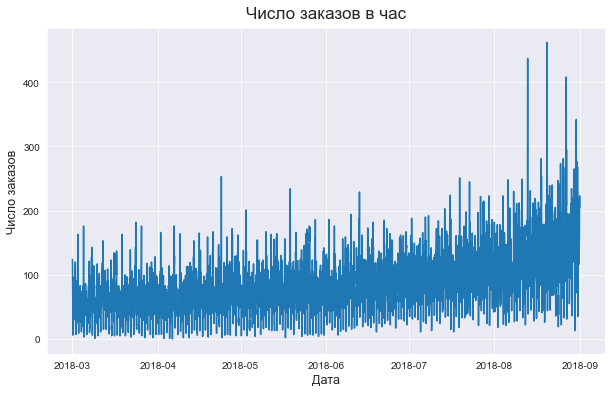

In [12]:
plt.figure(figsize=(10, 6))

plt.plot(taxi)

plt.xlabel('Дата', fontsize=12.5)
plt.ylabel('Число заказов', fontsize=12.5)
plt.title('Число заказов в час', size=17, y=1.01)

Хоть на графике и виден коридор значений и его небольшой рост, получиось не очень наглядно. Чтобы это исправить, разложим временной ряд на тренд, сезонность и остатки. Создадим функцию, которая будет строить их.

In [13]:
def plot_time_series_graph(data, graph):
    """
    Функция принимает данные, по которым будет строить график,
    и название необходимого графика.
    """
    decomposed = seasonal_decompose(data)
    
    plt.figure(figsize=(10, 6))
    plt.xlabel('Дата', fontsize=12.5)
    plt.ylabel('Число заказов', fontsize=12.5)
    
    if graph=='trend':
        decomposed.trend.plot(ax=plt.gca(), legend=None)
        plt.title('Тренд числа заказов в час', size=17, y=1.01)
    elif graph=='seasonal':
        decomposed.seasonal.plot(ax=plt.gca(), legend=None)
        plt.title('Сезонность числа заказов в час', size=15, y=1.01)
    elif graph=='resid':
        decomposed.resid.plot(ax=plt.gca(), legend=None)
        plt.title('Шумы в числе заказов в час', size=17, y=1.01)

### Тренд<a name="Тренд"></a>

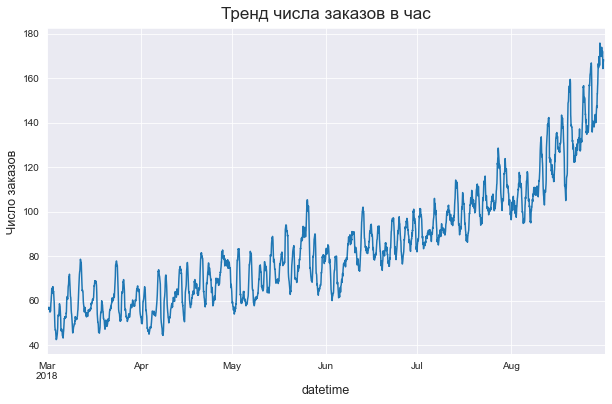

In [14]:
plot_time_series_graph(taxi, 'trend')
trend_graph = plt.gcf()

Виден восходящий тренд. Маловероятно, но возможно, что это сезонный месячный рост внутри года, а у нас просто не хватает данных для обнаружения такой «широкой» сезонности. В любом случае у нас короткий горизонт предсказания (час), поэтому мы можем считать кривую на графике трендом. 

### Сезонность<a name="Сезонность"></a>

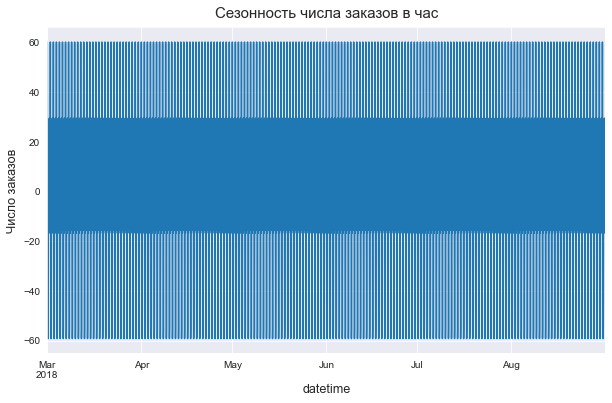

In [15]:
plot_time_series_graph(taxi, 'seasonal')

Сезонность, которую удалось «поймать», связана с периодом меньше месяца, поэтому «приблизим» график к последнему месяцу из данных.

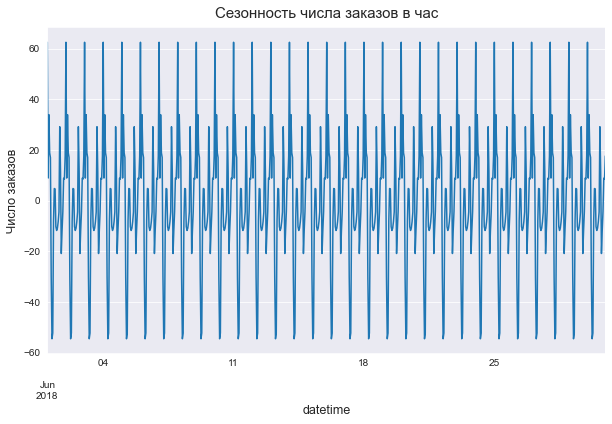

In [16]:
plot_time_series_graph(taxi['2018-06-01':'2018-06-30'], 'seasonal')

Cезонность стала четче, но все же рассмотрим ее на уровне недели. Возьмем период с 18 по 24 июня — это целая неделя с понедельника по воскресенье.

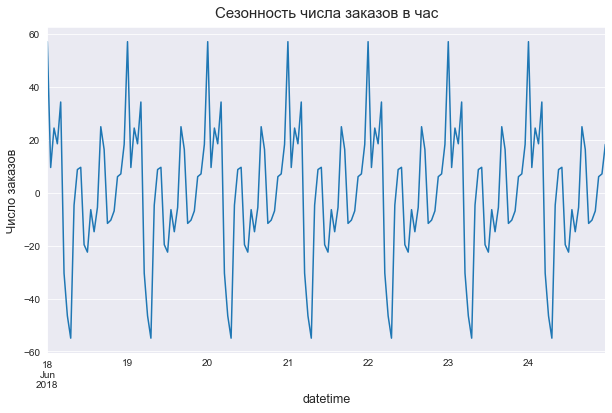

In [17]:
plot_time_series_graph(taxi['2018-06-18':'2018-06-24'], 'seasonal')
day_seasonal_graph = plt.gcf()

Чаще всего такси заказывают вечером и ночью, реже всего — ранним утром. Также есть всплески спроса в районе начала рабочего дня и в обед.

### Остатки<a name="Остатки"></a>

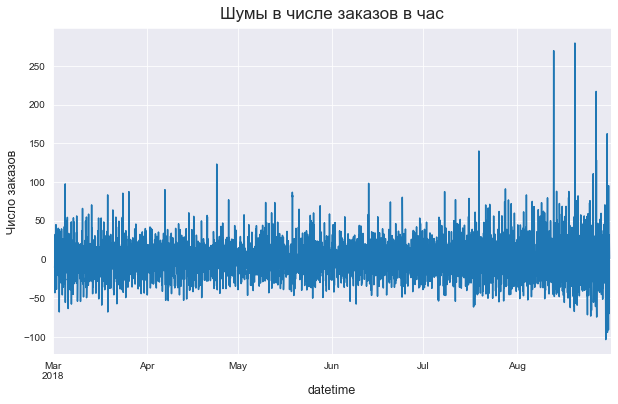

In [18]:
plot_time_series_graph(taxi, 'resid')
resid_graph = plt.gcf()

В конце периода виднеется несколько сильных выбросов в остатках. Скорее всего, они попадут в тестовую выборку и испортят качество предсказаний на ней.

[К содержанию](#Содержание)

## 3. Подготовка данных для обучения<a name="3.-Подготовка-данных-для-обучения"></a>

### Создание новых признаков<a name="Создание-новых-признаков"></a>

Перед обучением моделей добавим в данные новые признаки.
- номер дня недели и час дня, 
- лаги за сутки и за неделю,
- скользящее среднее за сутки.

#### Номер дня недели и часа в сутках

На графике сезонности мы увидили, что у нас есть сезонность недельная и суточная сезонности. Поэтому добавим в признаки номера дня недели и часа в сутках.

In [19]:
taxi['day_of_week'] = taxi.index.dayofweek
taxi['hour'] = taxi.index.hour

In [20]:
len(taxi)

4416

#### Лаги за сутки и за неделю

Еще один способ учесть суточную и недельную сезонности — добавить лаги по времени для этих временных отрезков. Сделаем это.

In [21]:
for lag in [24, 24*7]:
    taxi[f'lag_{lag}'] = taxi['num_orders'].shift(lag)

In [22]:
taxi.head()

,num_orders,day_of_week,hour,lag_24,lag_168
datetime,,,,,
2018-03-01 00:00:00,124.0,3,0,NaN,NaN
2018-03-01 01:00:00,85.0,3,1,NaN,NaN
2018-03-01 02:00:00,71.0,3,2,NaN,NaN
2018-03-01 03:00:00,66.0,3,3,NaN,NaN
2018-03-01 04:00:00,43.0,3,4,NaN,NaN


У данных за первые день и неделю нет лагов за день и неделю соответственно. Решим, что делать с пропусками позже, когда добавим все интересующие нас признаки.

#### Скользящее среднее

Скользящее среднее — аналог тренда, а он наблюдается в наших данных. Поэтому добавим в признаки скользящее среднее за неделю.

In [23]:
taxi['rolling_mean'] = taxi['num_orders'].shift()
taxi['rolling_mean'] = taxi['rolling_mean'].rolling(24*7).mean()

In [24]:
taxi.head()

,num_orders,day_of_week,hour,lag_24,lag_168,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124.0,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85.0,3,1,NaN,NaN,NaN
2018-03-01 02:00:00,71.0,3,2,NaN,NaN,NaN
2018-03-01 03:00:00,66.0,3,3,NaN,NaN,NaN
2018-03-01 04:00:00,43.0,3,4,NaN,NaN,NaN


### Обработка пропусков<a name="Обработка-пропусков"></a>

Посчитаем строки с пропусками и какую долю от всех они составляют.

In [25]:
nan_count = taxi[['lag_24', 'lag_168', 'rolling_mean']].isna().sum()
nan_count

lag_24           24
lag_168         168
rolling_mean    168
dtype: int64

Пропуски в `lag_168` и `rolling_mean` находятся в одних и тех же строках — данных за первую неделю. Для этих объектов невозможно посчитать недельные лаг и скользящее среднее, потому что у нас нет данных за более ранний период.

In [26]:
print('Доля пропусков: {:.2%}'.format(max(nan_count) / len(taxi)))

Доля пропусков: 3.80%


Строки с пропусками составляют менее 4% данных. Это немного, поэтому избавимся от них.

In [27]:
taxi = taxi.dropna()
taxi.head()

,num_orders,day_of_week,hour,lag_24,lag_168,rolling_mean
datetime,,,,,,
2018-03-08 00:00:00,143.0,3,0,100.0,124.0,54.226190
2018-03-08 01:00:00,78.0,3,1,121.0,85.0,54.339286
2018-03-08 02:00:00,65.0,3,2,24.0,71.0,54.297619
2018-03-08 03:00:00,68.0,3,3,66.0,66.0,54.261905
2018-03-08 04:00:00,60.0,3,4,73.0,43.0,54.273810


### Разделение данных на обучающую и тестовую выборки<a name="Разделение-данных-на-обучающую-и-тестовую-выборки"></a>

Мы не будем масштабировать признаки, так как наш временной ряд нестационарен. То есть со временен у него меняются среднее и стандартное отклонение. Значит, рассчитаные по старым данным метрики не подойдут для масштабирования будущих.

Выделим из данных целевой признак.

In [28]:
X = taxi.drop('num_orders', axis=1)
y = taxi['num_orders']

Для валидации валидации мы воспользуемся `GridSearchCV`, поэтому не будем выделять валидационную выборку и поделим данные только на трейн и тест.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

### Правило разбиения данных для GridSearch<a name="Правило-разбиения-данных-для-GridSearch"></a>

Для временных рядов не подойдет стандартное разбиение данных на фолды. В таком случае произойдет ситуация, когда модель обучается на данных из будущего, а валидируется на прошлом. Это неправильно.

Обучающие и валидационные выборки для временных рядов правильно составляет `TimeSeriesSplit`. Укажем количество разбиений равное 8 — тогда размер валидационной выборки будет примерно равен тестовой. Это нужно, чтобы результаты валидации и теста были больше похожи.

In [30]:
tss = TimeSeriesSplit(n_splits=8)

[К содержанию](#Содержание)

## 4. Обучение моделей<a name="4.-Обучение-моделей"></a>

Мы будем обучать модели тремя способами: линейной регрессией, стохастическим градиентым спуском и градиентным бустингом на деревьях решений.

### Линейная регрессия<a name="Линейная-регрессия"></a>

Для линейной регрессии мы не будем подбирать гиперпараметры. Но все равно обучим ее с помощью GridSearch, потому что иначе придется отдельно выделять валидационный датасет для проверки качества.

Оценивать модели будем по RMSE — качество по этой метрике интересуют заказчика. Также будем указывать `refit=True`, чтобы после определения лучшей модели GridSearch переобучал ее на всем тренировочном датасете. Это должно повысить качество предсказаний на тесте.

In [31]:
linreg = LinearRegression()

linreg_gs = GridSearchCV(
    estimator=linreg,
    param_grid={},
    scoring='neg_root_mean_squared_error',
    cv=tss,
    refit=True)

linreg_gs.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=LinearRegression(), param_grid={},
             scoring='neg_root_mean_squared_error')

In [32]:
print('Минимальный RMSE:', abs(linreg_gs.best_score_))

Минимальный RMSE: 23.62384348895238


### Стохастический градиентый спуск<a name="Стохастический-градиентый-спуск"></a>

In [33]:
sgd_model = SGDRegressor(random_state=SEED)

sgd_params = {
    'alpha' : [0.001, 0.1, 10, 100],
    'max_iter': [1e4, 1e5, 1e6],
    'learning_rate': ['optimal', 'invscaling'],
    'eta0': [1e-7, 1e-6, 1e-5]
}

sgd_gs = GridSearchCV(
    estimator=sgd_model,
    param_grid=sgd_params,
    scoring='neg_root_mean_squared_error',
    cv=tss,
    refit=True
)

sgd_gs.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=SGDRegressor(random_state=42),
             param_grid={'alpha': [0.001, 0.1, 10, 100],
                         'eta0': [1e-07, 1e-06, 1e-05],
                         'learning_rate': ['optimal', 'invscaling'],
                         'max_iter': [10000.0, 100000.0, 1000000.0]},
             scoring='neg_root_mean_squared_error')

In [34]:
print('Минимальный RMSE:', abs(sgd_gs.best_score_))
print('Лучшие гиперпараметры:', sgd_gs.best_params_)

Минимальный RMSE: 23.307759799686043
Лучшие гиперпараметры: {'alpha': 0.001, 'eta0': 1e-06, 'learning_rate': 'invscaling', 'max_iter': 10000.0}


### Градиентный бустинг<a name="Градиентный-бустинг"></a>

In [35]:
grboost = CatBoostRegressor(silent=True, random_seed=SEED)

grboost_params = {
    'iterations': [100, 200],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.001, 0.1]
}

grboost_gs = GridSearchCV(
    estimator=grboost,
    param_grid=grboost_params,
    scoring='neg_root_mean_squared_error',
    cv=tss,
    refit=True
)

grboost_gs.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f843f60b3a0>,
             param_grid={'iterations': [100, 200],
                         'learning_rate': [0.001, 0.1],
                         'max_depth': [6, 8, 10]},
             scoring='neg_root_mean_squared_error')

In [36]:
print('Минимальный RMSE градиентного бустинга:', abs(grboost_gs.best_score_))
print('Лучшие гиперпараметры:', grboost_gs.best_params_)

Минимальный RMSE градиентного бустинга: 23.386042216723
Лучшие гиперпараметры: {'iterations': 100, 'learning_rate': 0.1, 'max_depth': 6}


### Сравнение результатов<a name="Сравнение-результатов"></a>

In [37]:
train_results = [
    ['Линейная регрессия', abs(linreg_gs.best_score_)],
    ['Стохастический градиентный спуск', abs(sgd_gs.best_score_)],
    ['Градиентный бустинг', abs(grboost_gs.best_score_)],
]

train_results = pd.DataFrame(data=train_results,
                             columns=['Название', 'RMSE при валидации'])
train_results

,Название,RMSE при валидации
0,Линейная регрессия,23.623843
1,Стохастический градиентный спуск,23.307760
2,Градиентный бустинг,23.386042


RMSE на всех моделях почти одинаковая и находится в диапазоне от 23,3 до 23,6.

Для получения предсказаний на тестовой выборке возьмем стохастический градиентный спуск. Его результат хоть и ненамного, но лучше остальных моделей.

[К содержанию](#Содержание)

## 5. Предсказание для тестовой выборки<a name="5.-Предсказание-для-тестовой-выборки"></a>

Получим предсказания для тестовой выборки и проверим их качество.

In [38]:
def RMSE(y, predict):
    RMSE = round(mean_squared_error(y, predict, squared=False), 2)
    return RMSE

In [39]:
sdg_preds = sgd_gs.predict(X_test)

In [40]:
print('Среднеквадратическая ошибка на тестовой выборке:', RMSE(y_test, sdg_preds))

Среднеквадратическая ошибка на тестовой выборке: 35.91


In [41]:
print('Среднее число заказов в час в тестовой выборке:', round(y_test.mean(), 2))

Среднее число заказов в час в тестовой выборке: 140.09


Среднее число заказов в час в тестовой выборке — 140, поэтому ошибка в районе 36 равна 25%. Мне кажется, что это неплохой результат, если вспомнить, что в августе в остатках было много выбросов.

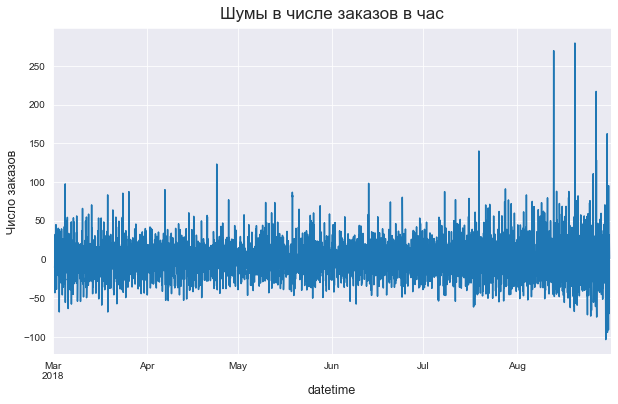

In [42]:
resid_graph

In [43]:
y_test

datetime
2018-08-14 07:00:00     54.0
2018-08-14 08:00:00     91.0
2018-08-14 09:00:00    135.0
2018-08-14 10:00:00    155.0
2018-08-14 11:00:00    162.0
                       ...  
2018-08-31 19:00:00    136.0
2018-08-31 20:00:00    154.0
2018-08-31 21:00:00    159.0
2018-08-31 22:00:00    223.0
2018-08-31 23:00:00    205.0
Freq: H, Name: num_orders, Length: 425, dtype: float64

Посмотрим, как предсказания модели отличаются от фактических значений. Рассмотрим короткий период в два дня, чтобы почасовую динамику было лучше видно.

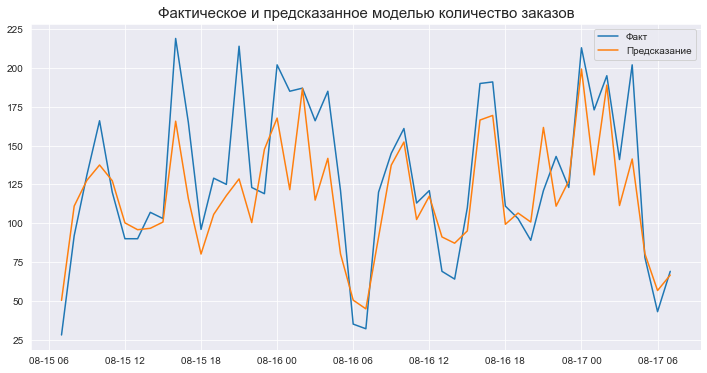

In [44]:
linreg_preds_series = pd.Series(data=sdg_preds, index=y_test.index)

plt.figure(figsize=(12, 6))
plt.plot(y_test['2018-08-15 07:00:00':'2018-08-17 07:00:00'], label='Факт')
plt.plot(linreg_preds_series['2018-08-15 07:00:00':'2018-08-17 07:00:00'], label='Предсказание')

plt.title('Фактическое и предсказанное моделью количество заказов', fontsize=15)
plt.legend()

preds_vs_y_graph = plt.gcf()

plt.show()

Графики предсказаний и факта имеют похожую форму — значит общие закономерности в данных модель поняла.

Однако видно, что в пиковые часы предсказания не догоняют факт: предсказанное число заказов ниже фактического. Это особенно видно по вечеру 15 августа: в пять и в девять часов был сильный спрос, который модель не удовлетворила.

[К содержанию](#Содержание)

## 6. Общий вывод<a name="6.-Общий-вывод"></a>

В начале работы мы познакомились с данными и выяснили, что в исследуемом периоде число заказов показывает восходящий тренд. 

Маловероятно, но возможно, что это сезонный месячный рост внутри года, а у нас просто не хватает данных для обнаружения такой «широкой» сезонности.

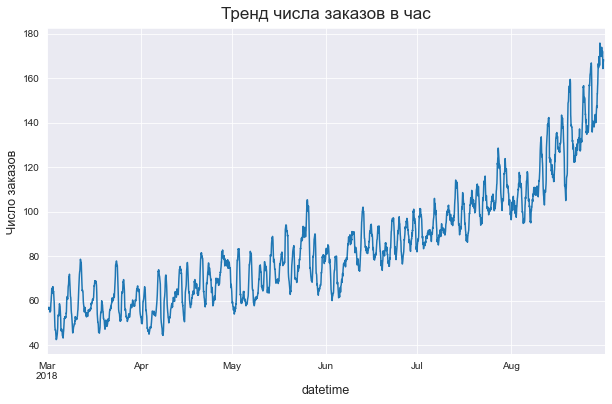

In [45]:
trend_graph

Также мы выяснили, что в количестве заказов есть сезонность на уровне дня. Чаще всего такси заказывают вечером и ночью, реже всего — ранним утром. Также есть всплески спроса в районе начала рабочего дня и в обед.

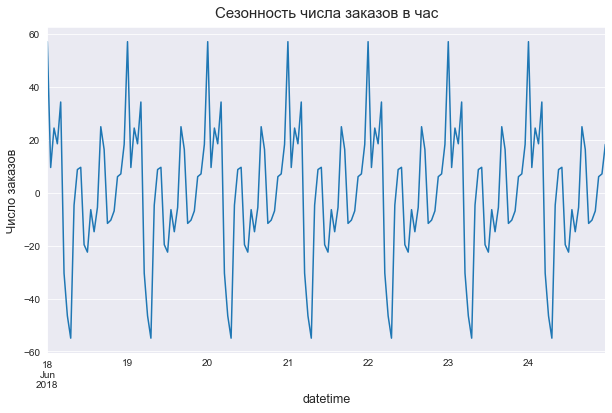

In [46]:
day_seasonal_graph

Затем мы перешли к предсказанию спроса. Для этого мы добавили в данные новые признаки:
- номер дня недели и часа в сутках,
- лаги за день и неделю,
- скользящее среднее за неделю.

После этого исследовали три алгоритма обучения моделей: линейную регрессию, стохастический градиентный спуск и градиентный бустинг — и подобрали для них оптимальные параметры. Результаты исследования:

In [47]:
train_results

,Название,RMSE при валидации
0,Линейная регрессия,23.623843
1,Стохастический градиентный спуск,23.307760
2,Градиентный бустинг,23.386042


С небольшим преимуществом победил стохастический градиентный спуск. С помощью него мы и получили предсказания для тестовой выборки.

In [48]:
print('Среднеквадратическая ошибка на тестовой выборке:', RMSE(y_test, sdg_preds))
print('Среднее число заказов в час в тестовой выборке:', round(y_test.mean(), 2))

Среднеквадратическая ошибка на тестовой выборке: 35.91
Среднее число заказов в час в тестовой выборке: 140.09


После этого мы проанализировали предсказания модели:

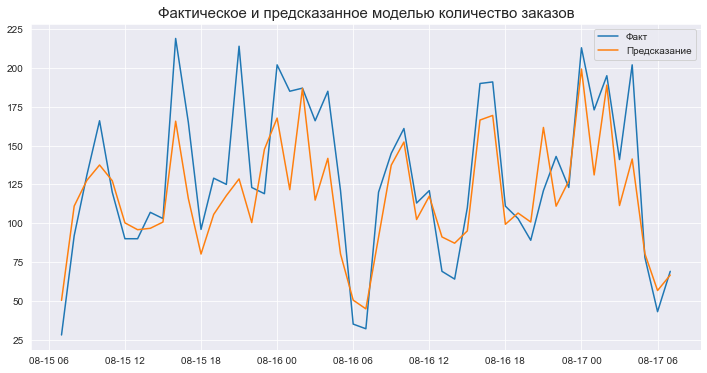

In [49]:
preds_vs_y_graph

Модель хорошо предсказывает «стандартное» число заказов, но не справляется с экстремумами. Причем разница между максимумами больше, чем между минимумами. Это значит, что в периоды повышенного спроса «Четенькому такси» будет не хватать водителей. Стоит учесть эту особенность при привлечении водителей.

[К содержанию](#Содержание)